# Crop Type Classification - Data Cleaning and visualization

This notebook illustrates the process of cleaning, preprocessing, and visualizing Normalized Difference Vegetation Index (NDVI) signature data. The resulting NDVI timeseries serves as input for training a crop type classification model in subsequent notebooks within this repository.

Outliers rejected by this workflow can be termed as non crop data. 

### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda create --name 'env_name' --file requirements.txt
$ conda activate 'env_name'
```

### Key Libraries:

- [Geopandas](https://geopandas.org/en/stable/docs.html), [Pandas]((https://xgboost.readthedocs.io/en/stable/)): Data handling and manipulation.
- [Matplotlib](https://matplotlib.org/stable/index.html): Utilized for data visualization.

### Meta Data information
- Crop types: Wheat, Mustard & Potato
- Time period recorded: fy 2022-23 (oct-22 to apr-23)
- Location: Madhya Pradesh, Uttar Pradesh
- Source: [Bhuvan Fasal(via MNCFC)](https://ncfc.gov.in/downloads/apps_update/FASAL_GT_CCE%20_Userguidelines.pdf) for Ground Truth and [Sentinel 2(via Google earth Engine)](https://developers.google.com/earth-engine/datasets/catalog/sentinel-2) for NDVI.

This workflow is performed on crop field data belonging to wheat, mustard and potato crops only (Bhuvan Fasal). However the same process can be extended to other crops grown in the Rabi season.

--------

# Imports

In [1]:
import os
try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-1]))
    kernel_is_loaded = True

from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import display
import random
from src.utils import _sowing_period, _harvest_period, _dip_impute, _less_than_150_drop

pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings("ignore")

# Seeding
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

# Initial Preprocessing

In [23]:
# Importing raw data present in the bronze format using pandas. 

data_path = 'data_files/raw_bronze_format.csv'

raw_data= pd.read_csv(data_path)

display(raw_data.head(5), raw_data.shape)

,crop_name,date,district,tehsil,geometry,state,ndvi_fn,ndvi_value
0,Potato,2022-10-01,Firozabad,Tundla,"POLYGON ((78.2806718365183 27.299023024220418,...",Uttar Pradesh,oct_1f,151.0
1,Potato,2022-10-01,Firozabad,Tundla,POLYGON ((78.27410578884984 27.298012424894072...,Uttar Pradesh,oct_1f,123.0
2,Potato,2022-10-01,Firozabad,Tundla,"POLYGON ((78.2759726063242 27.297669200388608,...",Uttar Pradesh,oct_1f,142.0
3,Potato,2022-10-01,Firozabad,Tundla,POLYGON ((78.28652978100682 27.296105608658422...,Uttar Pradesh,oct_1f,153.0
4,Potato,2022-10-01,Firozabad,Tundla,"POLYGON ((78.28820347943211 27.29936624454035,...",Uttar Pradesh,oct_1f,165.0


(185808, 8)

In [24]:
# Removing redundant columns and reorganizing and formatting essential ones.

data = gp.GeoDataFrame(raw_data[['geometry', 'ndvi_fn', 'ndvi_value']])
data = data.pivot_table(values=['ndvi_value'], index=['geometry'], columns=['ndvi_fn'], aggfunc='first')
data = data.droplevel(0, axis=1)
data['crop_name'] = raw_data.groupby('geometry')['crop_name'].first()
data = data.reset_index(drop=True).rename_axis(None, axis=1)
feature_order = ['oct_1f', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 
                     'feb_1f', 'feb_2f', 'mar_1f', 'mar_2f', 'apr_1f', 'apr_2f', 'crop_name']
data = data[feature_order]
outliers = pd.DataFrame(columns=feature_order)

display(data.head(5), data.shape)

,oct_1f,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,apr_2f,crop_name
0,161.0,133.0,141.0,165.0,179.0,186.0,186.0,183.0,183.0,154.0,127.0,124.0,119.0,117.0,Mustard
1,166.0,129.0,143.0,168.0,180.0,187.0,187.0,186.0,187.0,150.0,121.0,119.0,117.0,117.0,Mustard
2,160.0,154.0,134.0,132.0,157.0,181.0,187.0,189.0,185.0,187.0,165.0,133.0,124.0,122.0,Wheat
3,158.0,150.0,133.0,125.0,152.0,175.0,185.0,190.0,187.0,191.0,171.0,137.0,122.0,117.0,Wheat
4,155.0,123.0,145.0,183.0,189.0,189.0,184.0,170.0,151.0,116.0,117.0,116.0,114.0,113.0,Mustard


(13256, 15)

## Data cleaning and EDA

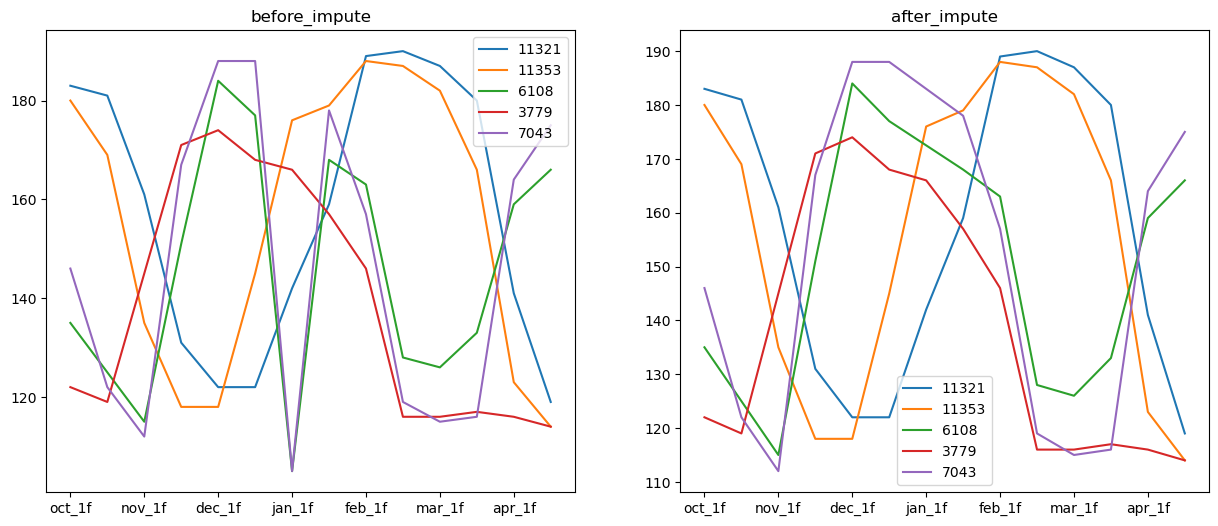

In [5]:
# If there is a significant drop of more than 20 in NDVI values for a specific fortnight, we impute the values using the average of neighboring fortnights.

before_impute = data.loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0)
data = data.apply(_dip_impute, axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

before_impute.T.plot(ax=axes[0],title='before_impute')
data.loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0).T.plot(ax=axes[1],title='after_impute')
plt.show()

__Determination of sowing period__

- Find the global minima of the time series containing scaled NDVI values ((NDVI *100)+100) from the first 5 fortnights.
- The chosen minima should have a value between 110-140.
- The successor of minima should have a slope of > 5.
- The fourth successive point from the minima should have a positive slope w.r.t the successor.
- If the minima doesn't satisfy the above criteria, consider the successive NDVI as the new probable sowing period and repeat the process.


In [6]:
# Sowing period determination

data['sowing_period'] = data.apply(_sowing_period, axis=1)

data.sowing_period.value_counts()

nov_1f     3759
nov_2f     2720
dec_1f     2381
Unknown    1678
oct_2f     1476
dec_2f      847
oct_1f      395
Name: sowing_period, dtype: int64

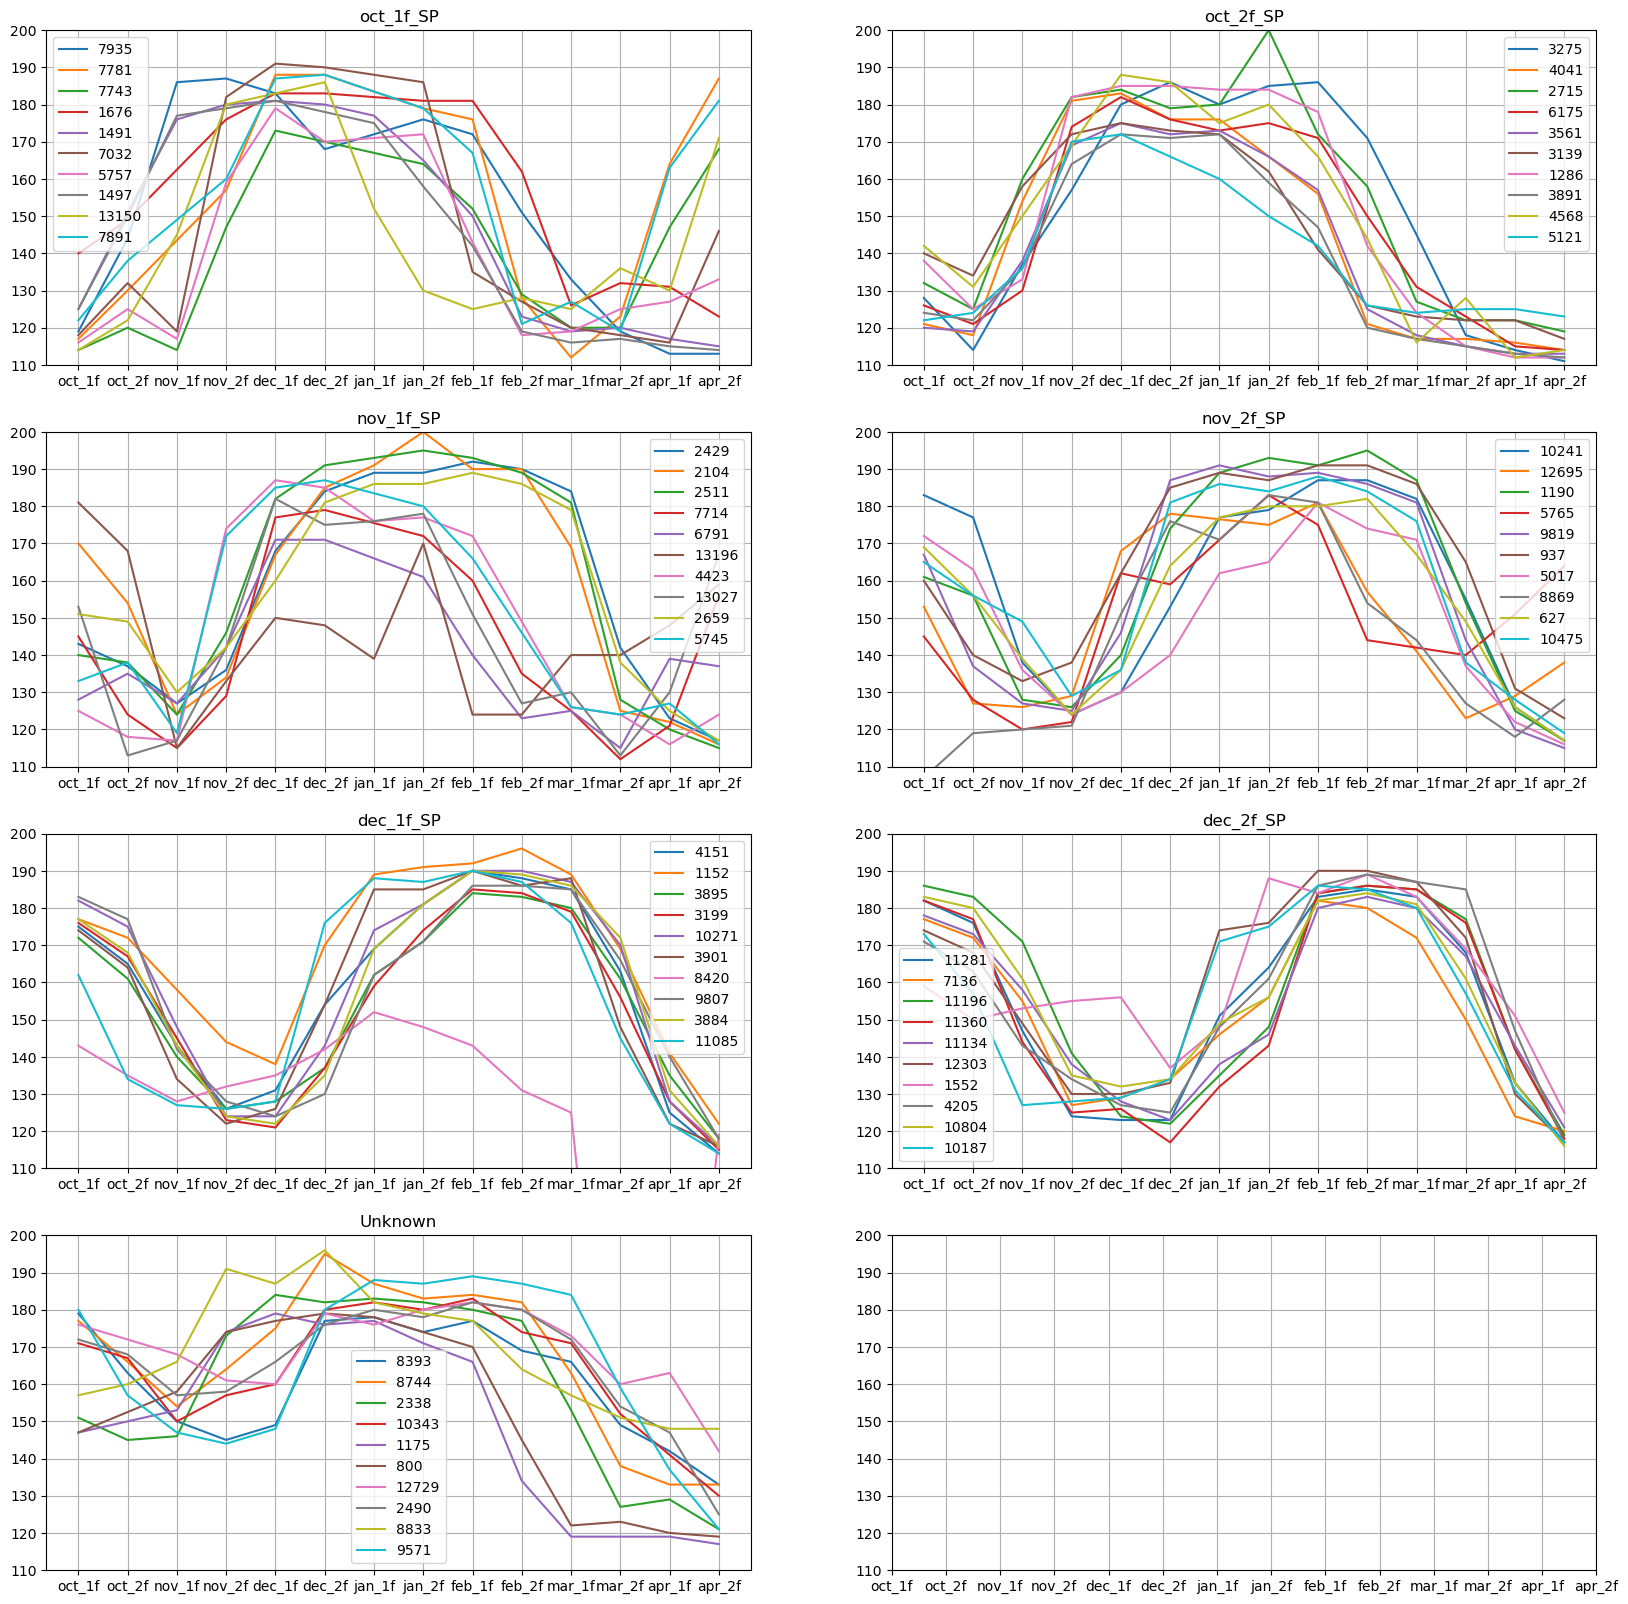

In [7]:
plt.rcParams['axes.grid'] = True

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

plt.setp(axes,  xticks = np.arange(0,14,1), xticklabels = data.loc[:,'oct_1f':'apr_2f'].columns,
         yticks=np.arange(60,220,10), ylim=[110,200])

data[data.sowing_period == 'oct_1f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=0).T.plot(ax=axes[0,0],
                                                                                         title='oct_1f_SP')
data[data.sowing_period == 'oct_2f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=0).T.plot(ax=axes[0,1],
                                                                                         title='oct_2f_SP')
data[data.sowing_period == 'nov_1f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=0).T.plot(ax=axes[1,0],
                                                                                         title='nov_1f_SP')
data[data.sowing_period == 'nov_2f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=0).T.plot(ax=axes[1,1],
                                                                                         title='nov_2f_SP')
data[data.sowing_period == 'dec_1f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=0).T.plot(ax=axes[2,0],
                                                                                         title='dec_1f_SP')
data[data.sowing_period == 'dec_2f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=0).T.plot(ax=axes[2,1],
                                                                                         title='dec_2f_SP')
data[data.sowing_period == 'Unknown'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=0).T.plot(ax=axes[3,0],
                                                                                         title='Unknown')

plt.show()

In [8]:
# Dropping the Unknown sowing period labels

new_outliers = data[data.sowing_period == 'Unknown']
outliers = pd.concat([outliers, new_outliers])

data.drop(new_outliers.index, inplace=True)

display(f'{new_outliers.shape[0]} dropped')

'1678 dropped'

__Determination of Harvest__

- Needs sowing period to determine harvest period.
- First fortnight value under 140 after Six fortnights or 3 months from the sowing period will be the first fortnight after harvest.

In [9]:
# Getting the harvest_period fortnight labels

data['harvest_period'] = data.apply(_harvest_period, axis=1)

data.harvest_period.value_counts()

mar_2f     4674
feb_1f     2090
feb_2f     2003
mar_1f     1801
apr_1f      621
jan_2f      327
jan_1f       32
Unknown      29
dec_2f        1
Name: harvest_period, dtype: int64

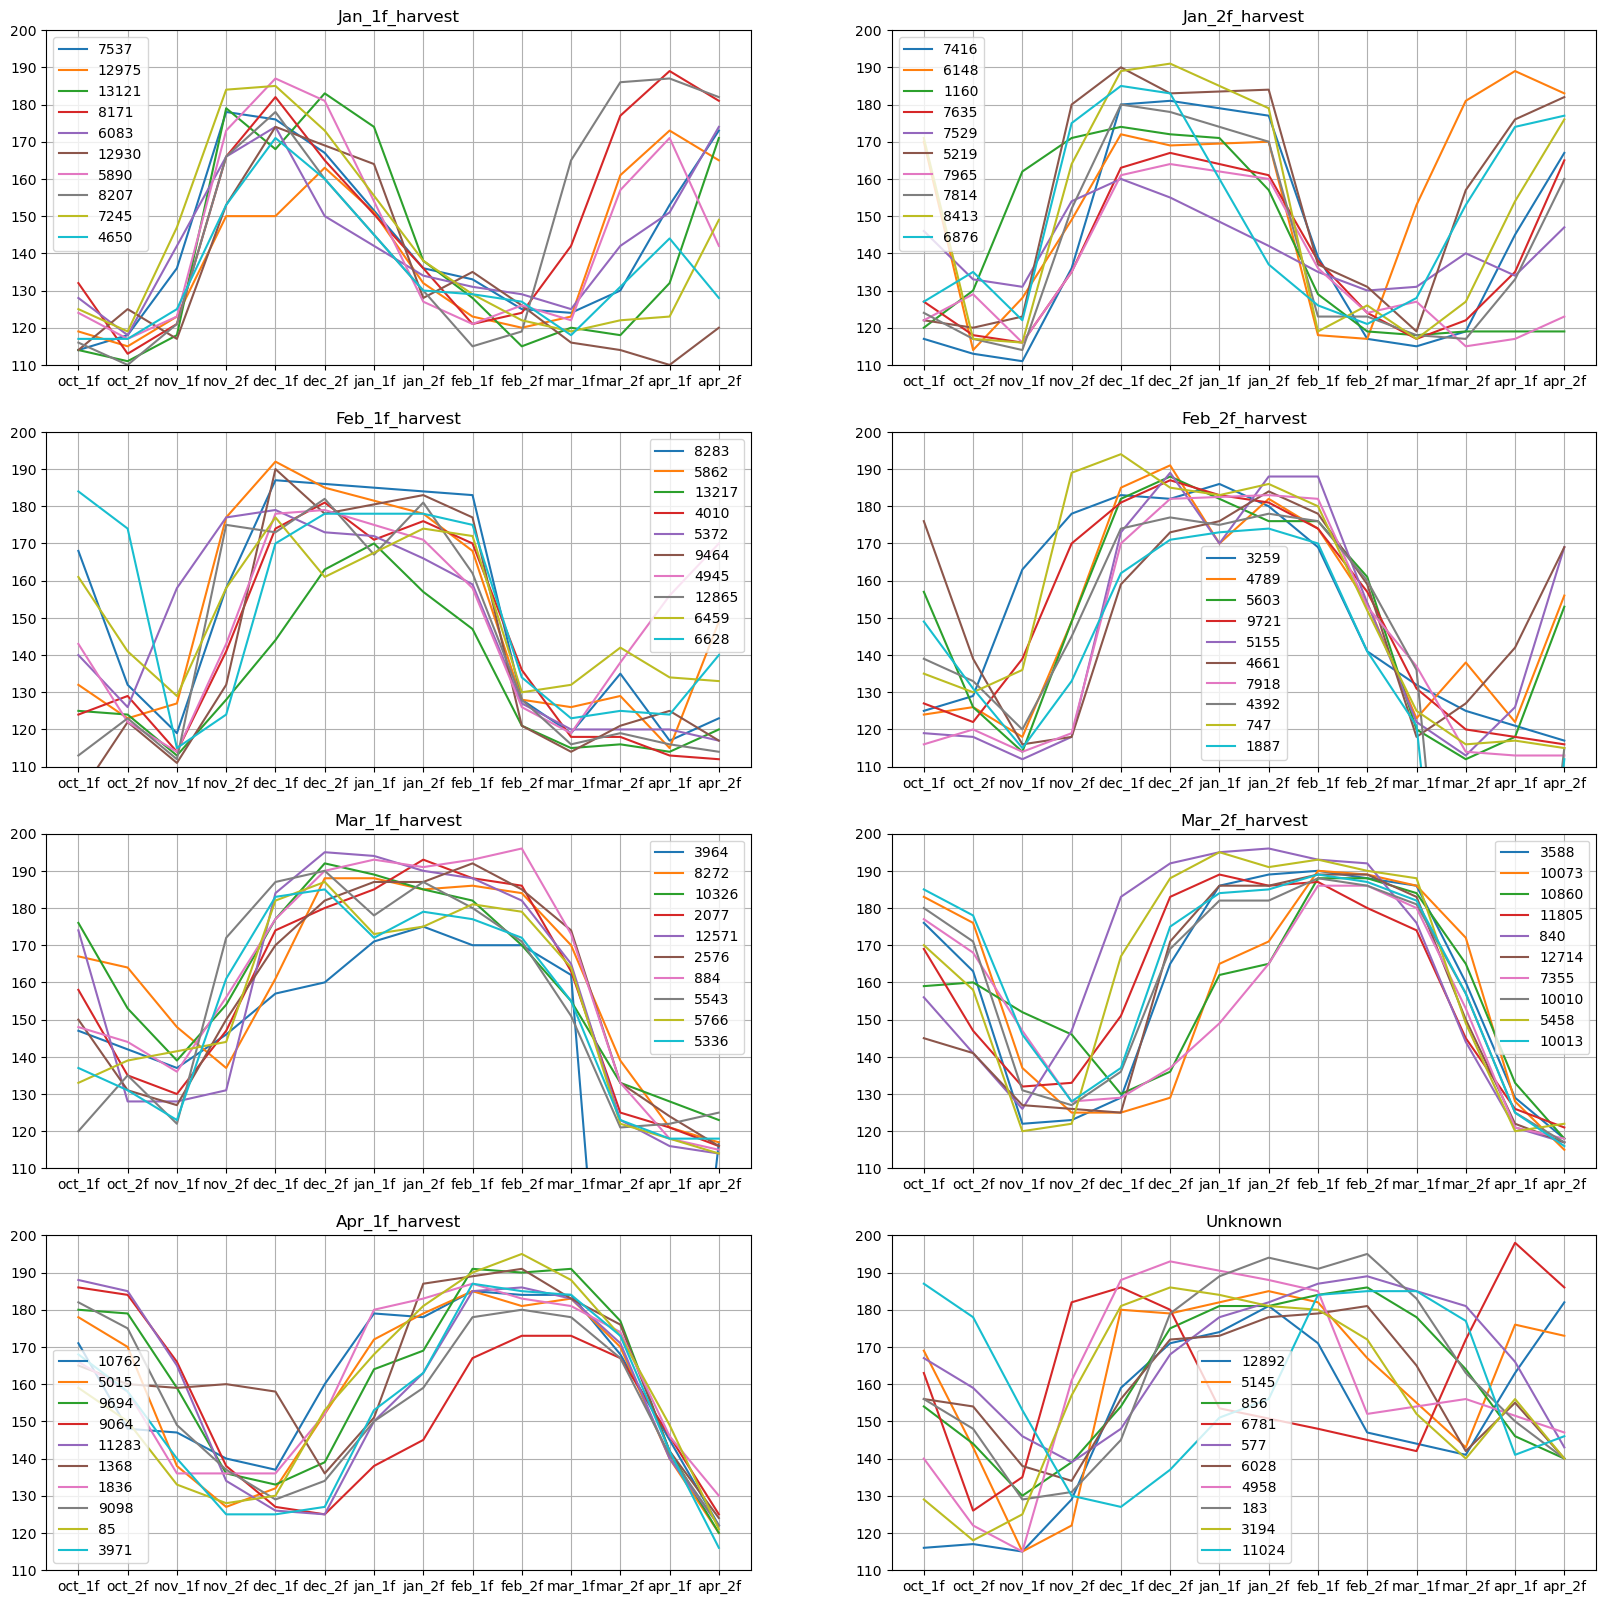

In [10]:


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

plt.setp(axes,  xticks = np.arange(0,14,1), xticklabels = data.loc[:,'oct_1f':'apr_2f'].columns,
         yticks=np.arange(60,220,10), ylim=[110,200])

data[data.harvest_period == 'jan_1f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=190).T.plot(ax=axes[0,0],
                                                                                         title='Jan_1f_harvest')
data[data.harvest_period == 'jan_2f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=190).T.plot(ax=axes[0,1],
                                                                                         title='Jan_2f_harvest')
data[data.harvest_period == 'feb_1f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=190).T.plot(ax=axes[1,0],
                                                                                         title='Feb_1f_harvest')
data[data.harvest_period == 'feb_2f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=190).T.plot(ax=axes[1,1],
                                                                                         title='Feb_2f_harvest')
data[data.harvest_period == 'mar_1f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=190).T.plot(ax=axes[2,0],
                                                                                         title='Mar_1f_harvest')
data[data.harvest_period == 'mar_2f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=190).T.plot(ax=axes[2,1],
                                                                                         title='Mar_2f_harvest')
data[data.harvest_period == 'apr_1f'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=190).T.plot(ax=axes[3,0],
                                                                                         title='Apr_1f_harvest')
data[data.harvest_period == 'Unknown'].loc[:,'oct_1f':'apr_2f'].sample(10, random_state=190).T.plot(ax=axes[3,1],
                                                                                         title='Unknown')

plt.show()

In [11]:
new_outliers = data[data.harvest_period == 'Unknown']
outliers = pd.concat([outliers, new_outliers])

# Dropping the Unknown harvest labels
data.drop(new_outliers.index, inplace=True)

display(f'{new_outliers.shape[0]} dropped', data.loc[:,'oct_2f':'apr_1f'].describe().T)

'29 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,11549.0,143.381332,19.404115,81.0,127.0,141.0,159.0,188.0
nov_1f,11549.0,132.694692,14.414812,96.0,122.0,131.0,142.0,195.0
nov_2f,11549.0,141.662785,18.453954,107.0,127.0,134.0,155.0,194.0
dec_1f,11549.0,156.892415,23.395746,112.0,133.0,159.0,180.0,200.0
dec_2f,11549.0,169.513638,19.534344,117.0,158.0,176.0,185.0,200.0
jan_1f,11549.0,176.056672,12.662049,104.0,169.0,179.0,186.0,200.0
jan_2f,11549.0,177.725063,11.299905,107.0,173.0,180.0,185.0,200.0
feb_1f,11549.0,178.241017,14.659684,109.0,173.0,184.0,188.0,197.0
feb_2f,11549.0,166.552342,24.108737,111.0,144.0,180.0,186.0,199.0
mar_1f,11549.0,155.964196,27.481393,93.0,125.0,170.0,181.0,196.0


'24 dropped'

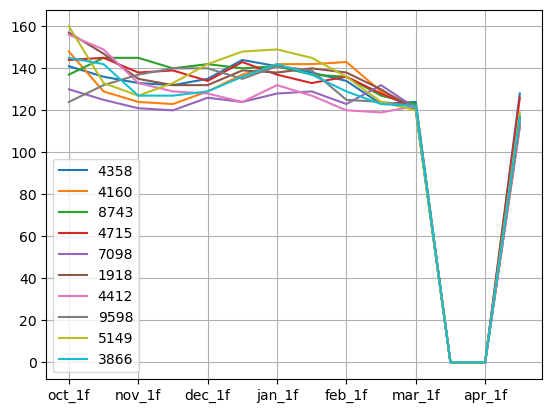

In [12]:
## Checking if there are rows which have max of NDVI values less than 150 for all the values between sp and hp.

new_outliers = data[data.apply(_less_than_150_drop, axis=1) == False]
outliers = pd.concat([outliers, new_outliers])

data = data.drop(new_outliers.index)

display(f'{new_outliers.shape[0]} dropped')

if new_outliers.shape[0] > 10:
    new_outliers.loc[:,'oct_1f':'apr_2f'].sample(10, random_state=0).T.plot()
else:
    new_outliers.loc[:,'oct_1f':'apr_2f'].T.plot()

plt.show()

# File Export

In [23]:
data.to_csv(r'data_files/preprocessed_data.csv', index=False)